In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [2]:
df = pd.read_csv('./references/09 data clean.csv')
pd.set_option('display.max_columns', None)

In [3]:
cats=['religionnew', 'ethnicitynew', 'educationnew', 'occupationnew',
       'incomenew', 'maritalnew', 'smokenew', 'alcoholnew', 'partnernew',
       'EV', 'CB', 'PV', 'SV', 'IPV']
conts=['Age']
dep="MINIdepression"

In [4]:
from fastai.tabular.all import *

In [5]:
splits = RandomSplitter()(df)

In [6]:
splits

((#73) [42,4,17,53,21,80,36,57,24,8...],
 (#18) [38,33,22,19,76,11,61,79,65,7...])

In [46]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=cats,
    cont_names=conts,
    y_names=dep, y_block=CategoryBlock(),
).dataloaders(path='.')

In [67]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.02754228748381138, valley=0.002511886414140463)

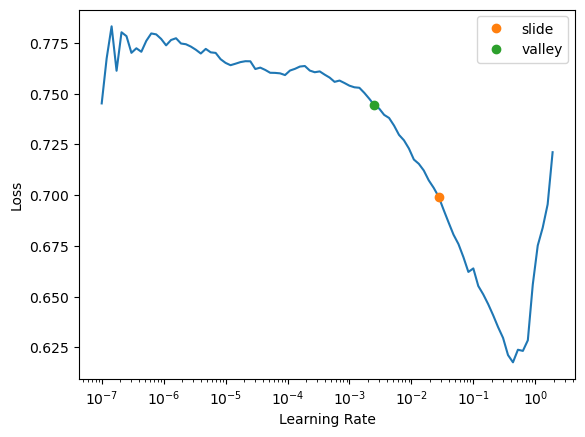

In [48]:
learn.lr_find(suggest_funcs=(slide, valley))

In [68]:
learn.fit(10, lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.843543,0.682116,0.611111,00:00
1,0.832645,0.677167,0.611111,00:00
2,0.829932,0.673833,0.611111,00:00
3,0.820496,0.671552,0.611111,00:00
4,0.813849,0.670179,0.611111,00:00
5,0.810277,0.669862,0.611111,00:00
6,0.793344,0.670432,0.611111,00:00
7,0.785635,0.671619,0.611111,00:00
8,0.774127,0.673274,0.611111,00:00
9,0.770539,0.675220,0.611111,00:00


In [29]:
# Checkpoint
# learn.save('model_94')

In [31]:
# Checkpoint Export
# learn.export('model_94_export')

In [28]:
learn.summary()

TabularModel (Input shape: 64 x 15)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 3              
Embedding                                 9          True      
Embedding                                 12         True      
____________________________________________________________________________
                     64 x 5              
Embedding                                 35         True      
____________________________________________________________________________
                     64 x 3              
Embedding                                 12         True      
____________________________________________________________________________
                     64 x 4              
Embedding                                 20         True      
____________________________________________________________________________
                     64 x 3              
Embedding                                 12         True     

In [69]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df
    bs = bs if bs is not None else learn.dls.bs
    if self.df is not None:
      self.dl = learn.dls.test_dl(self.df, bs=bs)
    else:
      self.dl = learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

In [70]:
trn_split,val_split=splits

In [71]:
trn_split

(#73) [17,40,89,75,6,60,33,35,4,1...]

In [72]:
df.iloc[trn_split]

,ID,Home,Age,Religion,Ethnicity,Education,Occupation,Income,Marital,Smoke,Smoking,Alcohol,Partner,P_Age,P_Education,P_Occupation,P_Alcohol,P_Drugs,P_Fights,P_Women,P_Child,SectionCQ1,SectionCQ2,SectionCQ3,SectionCQ4,SectionCQ5,SectionCQ6,SectionCQ7,SectionCQ8,SectionCQ9,SectionCQ10,SectionCQ11,SectionCQ12,SectionCQ13,SectionCQ14,SectionCQ15,SectionCQ16,SectionCQ17,SectionCQ18,SectionCQ19,SectionCQ20,SectionCQ21,SectionCQ22,SectionCQ23,SectionCQ24,SectionCQ25,SectionCQ26,SectionCQ27,SectionCQ28,SectionCQ29,SectionCQ30,SectionCQ31,SectionCQ32,SectionCQ33,SectionCQ34,SectionCQ35,SectionCQ36,SectionCQ37,SectionCQ38,SectionCQ39,SectionCQ40,SectionCQ41,SectionCQ42,SectionCQ43,SectionCQ44,SectionDQ1,SectionDQ1a,SectionDQ2,SectionDQ2a,SectionDQ3,SectionDQ3a,SectionDQ4,SectionDQ5,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,PHQ10,TPHQ,LDEPRESSION,PDEPRESSION,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,TANXIETY,Lanxiety,Panxiety,PCL1,PCL2,PCL3,PCL4,PCL5,PCL6,PCL7,PCL8,PCL9,PCL10,PCL11,PCL12,PCL13,PCL14,PCL15,PCL16,PCL17,PCL18,PCL19,PCL20,TPCL,PPTSD,MINI1,MINI1a,MINI2,MINI2a,MINI3,MINI4,MINI5,MINI6,MINI7,MINI8,MINI9,MINI10,MINI11,MINIdepression,EV,CB,PV,SV,IPV,filter_$,religionnew,ethnicitynew,incomenew,maritalnew,educationnew,occupationnew,smokenew,alcoholnew,partnernew
17,70,2,16,1,1,2,4,1,1,3,3,7,1,17,2,4,6,6,3,4,2,1,1,1,3,3,1,2,1,2,1,1,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,2,3,2,3,3,3,3,4,2,14,2,14,2,14,2,2,1,2,2,1,3,2,3,2,2,1,18,4,0,2,1,1,3,3,3,2,15,4,1,1,1,1,3,2,3,2,1,1,3,2,2,1,1,4,1,2,2,1,2,36,1,2,2,2,2,2,2,1,2,1,2,2,1,2,0,0,1,0,1,1,1,1,1,1,1,1,3,0,0,1
40,62,1,14,1,1,2,4,1,1,3,2,7,1,19,2,1,6,6,1,1,4,1,1,1,1,3,1,2,1,1,1,1,1,1,2,2,2,1,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,2,3,1,2,3,4,4,4,4,5,1,410,2,,2,,2,1,3,3,3,3,3,3,3,3,3,3,27,5,1,3,3,3,3,3,2,3,20,4,1,4,4,4,4,4,4,4,0,4,4,4,4,4,4,4,4,4,4,4,4,76,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,3,0,0,1
89,95,2,39,1,1,2,1,1,2,3,3,7,1,40,2,1,6,1,2,3,2,2,2,2,2,4,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,1,1,2,3,2,3,1,2,1,2,2,3,1,1,1,1,2,3,1,3,1,1,1,3,2,14,2,14,2,14,2,2,3,3,3,3,1,2,3,1,2,3,21,5,1,3,3,3,3,0,0,3,15,4,1,3,0,0,3,4,3,3,0,3,0,3,3,3,3,0,0,4,4,4,4,47,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,2,0,0,1
75,78,2,22,1,1,2,1,3,1,3,3,7,1,25,4,1,5,5,2,1,1,1,1,1,1,3,1,2,1,2,1,1,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,3,2,3,2,3,3,3,3,4,2,14,2,14,2,14,2,4,1,1,2,1,0,2,0,2,0,0,9,2,0,2,0,0,0,2,2,2,8,2,0,2,3,1,2,1,2,1,0,1,2,2,0,3,3,0,2,1,1,0,2,29,0,1,1,2,2,1,1,1,2,2,2,2,2,1,0,0,1,0,1,1,1,1,1,0,1,1,2,0,0,1
6,64,1,13,1,1,2,4,1,1,3,3,7,1,,6,6,7,7,4,5,6,2,2,2,2,1,2,2,2,2,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,2,,2,,2,,2,1,1,1,0,1,1,1,0,0,1,1,6,2,0,1,1,0,0,0,0,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,3,0,2,,2,,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,1,1,1,1,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,26,1,14,1,1,1,1,1,1,1,1,7,4,24,3,1,4,5,1,3,2,1,1,1,1,3,2,2,1,2,1,2,1,1,2,1,1,1,2,1,2,1,2,1,2,2,3,2,3,2,3,2,3,1,1,2,3,2,3,3,4,4,4,4,5,1,1,1,3,1,13,3,2,3,2,2,2,1,3,1,1,3,1,18,4,0,3,3,3,3,2,3,3,20,4,1,4,3,4,4,2,3,3,3,4,3,4,4,4,4,4,4,4,2,4,3,70,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,2,1,0,1
14,20,1,14,4,4,2,4,1,1,2,2,3,4,17,2,1,6,6,3,4,4,3,3,3,3,3,2,2,2,2,2,2,2,1,2,1,2,1,2,1,2,2,3,2,3,2,3,2,3,2,3,2,3,1,2,1,2,1,1,3,4,4,4,4,5,1,789,2,,1,79,1,1,1,1,1,1,1,2,1,2,3,1,13,3,0,2,2,3,2,2,1,3,15,4,1,1,3,0,4,3,2,1,0,4,0,4,3,4,4,0,0,4,4,4,1,46,1,1,1,1,1,1,2,2,1,1,1,1,2,1,1,1,0,0,1,1,1,0,0,1,1,1,3,1,2,1
41,73,2,17,1,1,2

Getting base error


Calculating Permutation Importance


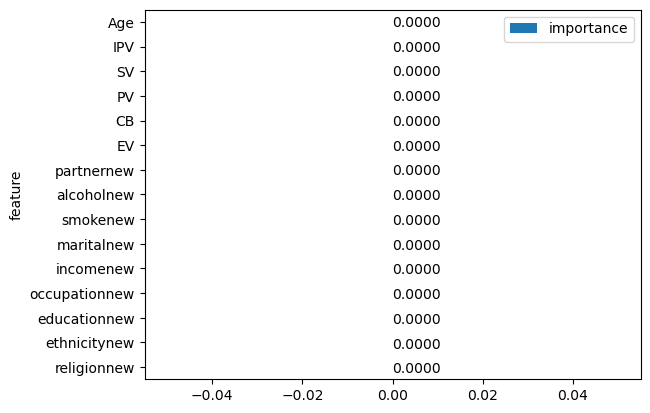

In [73]:
res = PermutationImportance(learn, df.iloc[trn_split], bs=64)

In [74]:
df.dtypes

ID               int64
Home             int64
Age              int64
Religion         int64
Ethnicity        int64
                 ...  
educationnew     int64
occupationnew    int64
smokenew         int64
alcoholnew       int64
partnernew       int64
Length: 147, dtype: object